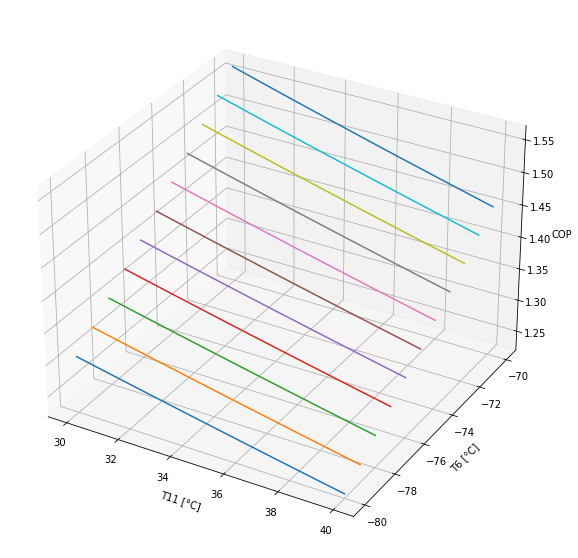

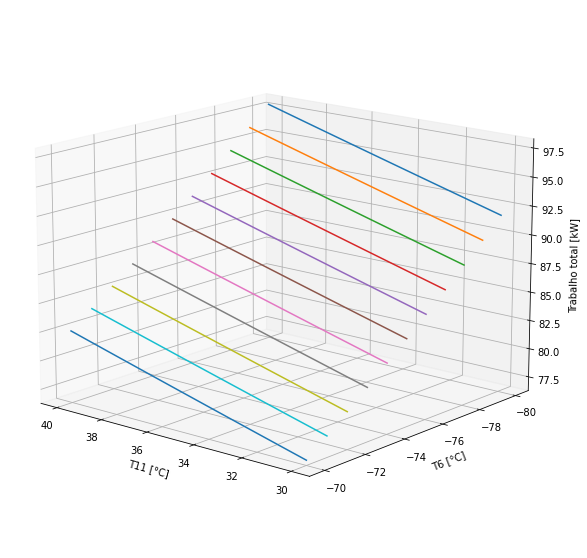

In [5]:
from CoolProp.CoolProp import PropsSI as CP
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import get_test_data
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

#Listas
T6_lista = []
T11_lista = []
Wcomp_total_lista = []
COP_lista = []
cont = []

#Lista de temperaturas de condensação
for i in range (30, 41, 1):
    cont.append(i+273.15)
    
#Dados do problema
Pfrig = 120 * 1000 #[W]
T3 = -8 + 273.15 #[K]
T7 = -12 + 273.15 #[K]
fluid_high = 'R717'
fluid_low = 'R41'
n = 1.1
drop_suc = 12000 #[Pa]
drop_desc = 24000 #[Pa]
efet = 0.7 #efetividade do trocador intermediário

#Pressão crítica do fluido superior
P_crit_high = CP('PCRIT', fluid_high)

#Ciclo inferior
P3 = CP('P', 'T', T3, 'Q', 0, fluid_low)
cp3 = CP('CP0MASS', 'T', T3, 'Q', 0, fluid_low)
h3 = CP('H', 'T', T3, 'Q', 0, fluid_low)
P4 = P3

#Ciclo superior
P7 = CP('P', 'T', T7, 'Q', 1, fluid_high)
h7 = CP('H', 'T', T7, 'Q', 1, fluid_high)
#CBP
hw = h7
Pw = P7 - drop_suc
Tw = CP('T', 'H', hw, 'P', Pw, fluid_high)
Px = Pw
Tx = Tw + 4 #superaquecimento de 4°C na admissão
vx = 1 / CP('D', 'T', Tx, 'P', Px, fluid_high)

#Loop nos dois ciclos - variação das temperaturas de evaporação e condensação
for T6 in range (-80, -69, 1):
    #Ciclo inferior
    T6 = T6 + 273.15
    P6 = CP('P', 'T', T6, 'Q', 1, fluid_low)
    cp6 = CP('CP0MASS', 'T', T6, 'Q', 1, fluid_low)
    h6 = CP('H', 'T', T6, 'Q', 1, fluid_low)
    P1 = P6
    #Comparação entre os calores específicos nos pontos 3 e 6
    if cp6 < cp3:
        T1 = efet * (T3 - T6) + T6
        h1 = CP('H', 'T', T1, 'P', P1, fluid_low)
        ha = h1
        Pa = P1 - drop_suc
        Ta = CP('T', 'H', ha, 'P', Pa, fluid_low)
        Pb = Pa
        Tb = Ta + 4 #considerei um superaquecimento de 4°C na admissão
        vb = 1 / CP('D', 'T', Tb, 'P', Pb, fluid_low)
        P2 = P3
        Pc = P2 + drop_desc
        h4 = h3 + h6 - h1
        T4 = CP('T', 'H', h4, 'P', P4, fluid_low)
        h5 = h4
    else:
        T4 = T3 - efet * (T3 - T6)
        h4 = CP('H', 'T', T4, 'P', P4, fluid_low)
        h1 = h3 + h6 - h4
        T1 = CP('T', 'H', h1, 'P', P1, fluid_low)
        v1 = 1 / CP('D', 'T', T1, 'P', P1, fluid_low)
        ha = h1
        Pa = P1 - drop_suc
        Ta = CP('T', 'H', ha, 'P', Pa, fluid_low)
        Pb = Pa
        Tb = Ta + 4 #considerei um superaquecimento de 4°C na admissão
        vb = 1 / CP('D', 'T', Tb, 'P', Pb, fluid_low)
        P2 = P3
        Pc = P2 + drop_desc
        h5 = h4
    m_flow_low = Pfrig / (h6 - h5)
    vc = (Pb * vb ** n / Pc)**(1 / n)
    hc = CP('H', 'P', Pc, 'D', 1 / vc, fluid_low)
    h2 = hc
    #Trabalho específico do compressor do ciclo inferior
    w_low = n / (n-1) * Pb * vb * ((Pc/Pb)**((n-1)/n) - 1)
    #Trabalho do compressor do ciclo inferior
    Wcomp_low = m_flow_low * w_low
    #Calor trocado no trocador central
    Qcond_low =  m_flow_low * (h2 - h3)
    for T11 in cont:
        #Ciclo superior
        Qevap_high = Qcond_low
        P11 = CP('P', 'T', T11, 'Q', 0, fluid_high)
        h11 = CP('H', 'T', T11, 'Q', 0, fluid_high)
        h12 = h11
        P10 = P11
        #Pressão intermediária
        P_int = (P7 * P11) ** 0.5
        P8 = P_int
        P9 = P_int
        P12 = P_int
        P13 = P_int
        h13 = CP('H', 'P', P13, 'Q', 0, fluid_high)
        h14 = h13
        h9 = CP('H', 'P', P9, 'Q', 1, fluid_high)
        Py = P8 + drop_desc
        #CBP
        m_CBP = Qevap_high / (h7 - h14)
        vy = (Px * vx ** n / Py)**(1 / n)
        hy = CP('H', 'P', Py, 'D', 1 / vy, fluid_high)
        h8 = hy
        #Trabalho específico do CBP
        w_CBP = n / (n-1) * Px * vx * ((Py/Px)**((n-1)/n) - 1)
        #Trabalho do CBP
        W_CBP = m_CBP * w_CBP
        #CAP
        m_CAP = m_CBP * (h13 - h8) / (h12 - h9)  
        he = h9
        Pe = P9 - drop_suc
        Te = CP('T', 'H', he, 'P', Pe, fluid_high)
        Pf = Pe
        Tf = Te + 4 #considerei um superaquecimento de 4°C na admissão
        vf = 1 / CP('D', 'T', Tf, 'P', Pf, fluid_high)
        Pg = P10 + drop_desc
        vg = (Pf * vf ** n / Pg)**(1 / n)
        #Verificação da pressão crítica
        if P_crit_high > P10:
            T6_lista.append(T6 - 273.15)
            T11_lista.append(T11 - 273.15)
            #Registro dos graus de subresfriamento e superaquecimento
            grau_subresf = T3 - T4
            grau_superaq = T1 - T6         
            #print('O grau de subresfriamento (T6 = {:0.2f}°C, T11 = {:0.2f}°C) é igual a {:0.2f}°C.'.
                  #format(T6-273.15, T11-273.15, grau_subresf))
            #print('O grau de superaquecimento (T6 = {:0.2f}°C, T11 = {:0.2f}°C) é igual a {:0.2f}°C.'.
                  #format(T6-273.15, T11-273.15,grau_superaq))
            #Trabalho específico do CAP
            w_CAP = n / (n-1) * Pf * vf * ((Pg/Pf)**((n-1)/n) - 1)
            #Trabalho do CAP
            W_CAP = m_CAP * w_CAP
            #Trabalho total do ciclo superior
            Wcomp_high = W_CAP + W_CBP
            #Trabalho total do ciclo
            Wcomp_total = Wcomp_low + Wcomp_high
            Wcomp_total_lista.append(Wcomp_total / 1000)
            #COP
            COP = Pfrig / Wcomp_total
            COP_lista.append(COP)
        else:
            print ('A pressão P10 = {:0.2f} kPa (T6 = {:0.2f}°C, T11 = {:0.2f}°C) é maior do que a ' 
               'pressão crítica do {} e, por isso, o ponto não foi incluído no gráfico'
                   .format(P10/1000,T6-273.15,T11-273.15,fluid_high))

if len(T6_lista) !=0:
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1, projection ='3d')
    for i in range (0, len(COP_lista), len(cont)):
        x1line = []
        y1line = []
        z1line = []
        for j in range (i, i + len(cont), 1):
            y1line.append(T6_lista[i])
            x1line.append(T11_lista[j])
            z1line.append (COP_lista[j])
        ax.set_xlabel('T11 [°C]', size = 10)
        ax.set_ylabel('T6 [°C]', size = 10)
        ax.set_zlabel('COP', size = 10)
        ax.plot3D(x1line, y1line, z1line)   
    plt.show()
else:
    print ('Todos os pontos são inválidos')
    
if len(T6_lista) !=0:
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1, projection ='3d')
    for i in range (0, len(Wcomp_total_lista), len(cont)):
        x1line = []
        y1line = []
        z1line = []
        for j in range (i, i + len(cont), 1):
            y1line.append(T6_lista[i])
            x1line.append(T11_lista[j])
            z1line.append (Wcomp_total_lista[j])
        ax.set_xlabel('T11 [°C]', size = 10)
        ax.set_ylabel('T6 [°C]', size = 10)
        ax.set_zlabel('Trabalho total [kW]', size = 10)
        ax.plot3D(x1line, y1line, z1line)   
        ax.view_init(15,130)
    plt.show()
else:
    print ('Todos os pontos são inválidos')